The goal is to show how to plot geophysical fields using for instance pcolor, over a background consisting of a visible, satellite image, using
1. [`Basemap`](https://matplotlib.org/basemap/).
2. [`Cartopy`](https://scitools.org.uk/cartopy/docs/latest/).
The data file is not provided but (hopefully) the procedure is clear enough that it can be with any dataset.

In [38]:
import os
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
import netCDF4
import numpy as np
import matplotlib.colors as colors
import cmocean
from osgeo import gdal, osr
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

These lines to get rid of some `Matplotlib` warnings.

In [53]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

## Data
We will use:
1. Sentinel-2 image (geoTIFF format) downloaded from the [Sentinel-Hub](https://apps.sentinel-hub.com/eo-browser/?lat=57.991&lng=18.620&zoom=9&time=2019-08-09&preset=1_TRUE_COLOR&atmFilter=DOS1&datasource=Sentinel-2%20L2A) browser and 
2. A netCDF file containg measurements of chlorophyll concentration, also Sentinel-2.

In [54]:
imagefile = "/data/Visible/Sentinel-2_L2A_2019-08-09c.tiff"
datafile = "/data/Sentinel2/S2A_MSI_2019_08_09_10_00_31_T34VCK_L2W.nc"
os.path.exists(imagefile) & os.path.exists(datafile)

True

### Data reading
For the netCDF we load the coordinates and the field:

In [55]:
with netCDF4.Dataset(datafile) as nc:
    lon = nc.variables["lon"][:]
    lat = nc.variables["lat"][:]
    chl_oc3 = nc.variables["chl_oc3"][:]

### Visible image reading
The image was downloaded as a high-resolution geoTIFF with the WGS 84 coordinate system.   
The function to read the file is detailed in this [post](https://ctroupin.github.io/posts/2019-08-30-basemap_geotiff/).

In [56]:
def read_geotiff(filename):
    """
    Read an image and compute the coordinates from a geoTIFF file
    """
    ds = gdal.Open(filename, gdal.GA_ReadOnly)
    ds.GetProjectionRef()
    # Read the array and the transformation
    arr = ds.ReadAsArray()
    trans = ds.GetGeoTransform()
    extent = (trans[0], trans[0] + ds.RasterXSize*trans[1],
    trans[3] + ds.RasterYSize*trans[5], trans[3])
    
    # Get the info on the projection
    proj = ds.GetProjection()
    inproj = osr.SpatialReference()
    inproj.ImportFromWkt(proj)

    arr = np.transpose(arr, (1, 2, 0))

    x = np.arange(0, ds.RasterXSize)
    y = np.arange(0, ds.RasterYSize)
        
    xx, yy = np.meshgrid(x, y)

    lon = trans[1] * xx + trans[2] * yy + trans[0]
    lat = trans[4] * xx + trans[5] * yy + trans[3]
        
    return lon, lat, arr, extent, inproj

In [57]:
lon_vis, lat_vis, image_vis, extent, inproj = read_geotiff(imagefile)
print(inproj)

GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]


The variable `extent` stores the image geographical domain: 

In [58]:
print(extent)

(16.182861328125004, 21.305236816406254, 57.5290963291026, 58.91599192355906)


## Create the plot
### Projection
With `Basemap` we start by creating the projection.

In [59]:
m = Basemap(projection='merc',
        llcrnrlon=extent[0], llcrnrlat=extent[2],
        urcrnrlon=extent[1], urcrnrlat=extent[3],
        lat_ts= 0.5 * (extent[2] + extent[3] ), resolution="h")

### Test 1
For the tests, it is better to sub-sample the field to display, this is why we add the `[::NN, ::NN]` after the variables.

/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


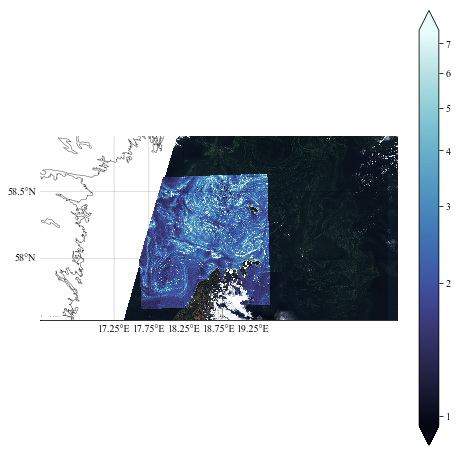

In [60]:
NN = 20
plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
# Add the visible image
m.imshow(image_vis, origin='upper', zorder=4)

pcm = m.pcolormesh(lon[::NN, ::NN], lat[::NN, ::NN], chl_oc3[::NN, ::NN], latlon=True,
           norm=colors.LogNorm(vmin=0.95, vmax=7.5), cmap=cmocean.cm.ice, zorder=5)

cb = plt.colorbar(pcm, extend="both")
cb.set_ticks(np.arange(0, 10))
cb.set_ticklabels(["1", "2", "3", "4", "5", "6", "7"])

m.drawcoastlines(linewidth=0.5, zorder=6, color=".3")
m.drawmeridians(np.arange(17.25, 19.55, 0.5),
                labels=(0,0,0,1), linewidth=.25, zorder=6, fontsize=10)
m.drawparallels(np.arange(57.5, 59., 0.5),
                labels=(1,0,0,1), linewidth=.25, zorder=6, fontsize=10)

plt.show()
plt.close()

### Test 2
It is not too bad but the limits are taken from the visible image, while we might prefer to use the field (chlorophyll concentration) extent. Here is the new projection:

In [61]:
m2 = Basemap(projection='merc',
        llcrnrlon=lon.min(), llcrnrlat=lat.min(),
        urcrnrlon=lon.max(), urcrnrlat=lat.max(),
        lat_ts= 0.5 * (lat.min() + lat.max() ), resolution="h")

If we apply the same plotting code as before, it won't work correctly...

/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


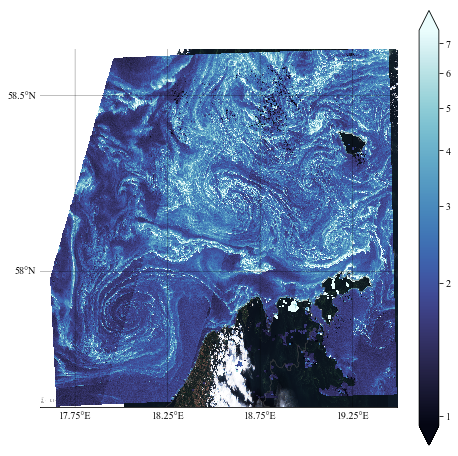

In [62]:
NN = 20
plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
# Add the visible image
m2.imshow(image_vis, origin='upper', zorder=4)

pcm = m2.pcolormesh(lon[::NN, ::NN], lat[::NN, ::NN], chl_oc3[::NN, ::NN], latlon=True,
           norm=colors.LogNorm(vmin=0.95, vmax=7.5), cmap=cmocean.cm.ice, zorder=5)

cb = plt.colorbar(pcm, extend="both")
cb.set_ticks(np.arange(0, 10))
cb.set_ticklabels(["1", "2", "3", "4", "5", "6", "7"])

m2.drawcoastlines(linewidth=0.5, zorder=6, color=".3")
m2.drawmeridians(np.arange(17.25, 19.55, 0.5),
                labels=(0,0,0,1), linewidth=.5, zorder=6, fontsize=10)
m2.drawparallels(np.arange(57.5, 59., 0.5),
                labels=(1,0,0,1), linewidth=.5, zorder=6, fontsize=10)

plt.show()
plt.close()

It might look ok, but it is not: the visible background does not correspond to the field displayed with `pcolormesh` (you can check with the position of the clouds).

### Test 3: subset visible image
We will take only the part of the visible image that corresponds to our domain, as defined by the chlorophyll field.     
**Note:** this will work only if the visible image domain encompasses the field we want to plot over it.

In [64]:
domain = (lon.min(), lon.max(), lat.min(), lat.max())

We create a short function for the extraction of a sub-domain of the geoTIFF.

In [65]:
def extract_area(lonvis, latvis, arrayvis, coordinates):
    """
    Extract the visible image in the region of interest
    """
    llon = lonvis[0]
    llat = np.array([lats[0] for lats in latvis])
    goodlon = np.where( (llon <= coordinates[1]) & (llon >= coordinates[0]))[0]
    goodlat = np.where( (llat <= coordinates[3]) & (llat >= coordinates[2]))[0]

    arrayvis = arrayvis[goodlat,:,:]
    arrayvis = arrayvis[:,goodlon,:]
    
    return arrayvis

In [66]:
image_sel = extract_area(lon_vis, lat_vis, image_vis, domain)

#### Create the plot

/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


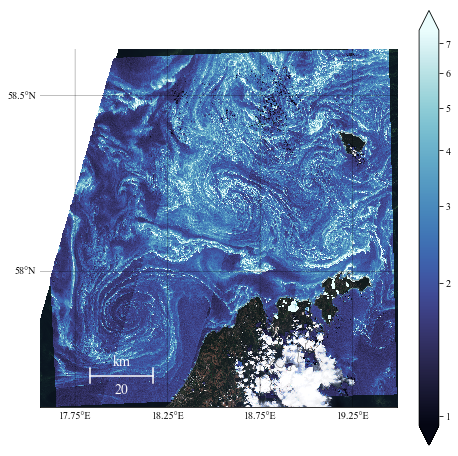

In [67]:
NN = 20
plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
# Add the visible image
m2.imshow(image_sel, origin='upper', zorder=4)

pcm = m2.pcolormesh(lon[::NN, ::NN], lat[::NN, ::NN], chl_oc3[::NN, ::NN], latlon=True,
           norm=colors.LogNorm(vmin=0.95, vmax=7.5), cmap=cmocean.cm.ice, zorder=5)

cb = plt.colorbar(pcm, extend="both")
cb.set_ticks(np.arange(0, 10))
cb.set_ticklabels(["1", "2", "3", "4", "5", "6", "7"])

m2.drawcoastlines(linewidth=0.5, zorder=6, color=".3")
m2.drawmeridians(np.arange(17.25, 19.55, 0.5),
                labels=(0,0,0,1), linewidth=.5, zorder=6, fontsize=10)
m2.drawparallels(np.arange(57.5, 59., 0.5),
                labels=(1,0,0,1), linewidth=.5, zorder=6, fontsize=10)

m2.drawmapscale(18., 57.7, 18., 57.7, 20., barstyle='simple', units='km', 
                fontsize=14, yoffset=None, labelstyle='simple', fontcolor='w', zorder=7)
# plt.savefig("./chl_oc3_V24.png", dpi=600, bbox_inches="tight")
plt.show()
plt.close()

## Cartopy
The code is almost the same. We just have to use:
* the arguments *extent* and *transform* in the `imshow()` call;
* the methods `set_xlim()` and `set_ylim()` to limit the domain.

/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


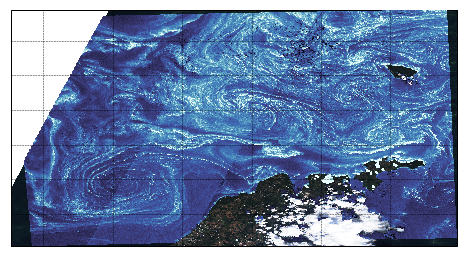

In [51]:
myproj = ccrs.Mercator()
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection=myproj)
ax.imshow(image_vis, origin='upper', extent=extent, transform=myproj)
ax.coastlines(resolution='10m', color="0.8")
plt.pcolormesh(lon[::NN, ::NN], lat[::NN, ::NN], chl_oc3[::NN, ::NN], 
               transform=myproj, norm=colors.LogNorm(vmin=0.95, vmax=7.5), 
               cmap=cmocean.cm.ice, zorder=5)
gl = ax.gridlines(crs=myproj, linewidth=.5, color='black', alpha=0.9, linestyle='--', zorder=6)
gl.xlabels_top = False
gl.ylabels_left = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.set_xlim(lon.min(), lon.max())
ax.set_ylim(lat.min(), lat.max())
plt.show()

The projection is not exactly the same as with `Basemap`, but we'll solve that later.